(hgf_exercises)=
# Hierarchical Gaussian Filter modelling exercises

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    ! pip install pyhgf

In [10]:
from pyhgf import load_data
from pyhgf.model import HGF
import pandas as pd

# load example dataset
timeseries = load_data("continuous")

In this notebook you are going to learn the core principles on whic the HGF is built, you will build agents that can filter new observations and update their beliefs about hidden states of the world and try to optimize them so they are getting less and less surprised about what is happening. Finally, you will create and agent that tries to optimize its behavior when facing (almost) unpredictable events.

## Gaussian random walks

The generative model on which the HGF is built is a generalisation of the [Gaussian Random Walk](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk) (GRW). A GRW generate a new observation $x_1^{(k)}$ at each time step $k$ from a normal distribution and using the previous observation $x_1^{(k-1)}$ such as:

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)}, \sigma^2)
$$

where $\sigma^2$ is the variance of the distribution. 

```{admonition} Exercise 1
Using the equation above, write a Python code that implements a Gaussian random walk using the following parameters: $\sigma^2 = 1$ and $x_1^{(0)} = 0$.
```

## Volatility coupling

The HGF generalize this process by making the parameters of a GRW depends on another GRW at a higher level. This kind of dependeny is termed "coupling" and can target the volatiliy ($\sigma^2$) of the value ($\mu$), or both. 

If we take as example the two-level continuous HGF {cite:p}`2014:mathys`, the model is constituded of two states of interest, $x_1$ and $x_2$. The node $x_1$ is performing a GRW, but it is also paired with $x_2$ via *volatility coupling*. This means that for state $x_1$, the mean of the Gaussian random walk on time point $k$ is given by its previous value $x_1^{(k-1)}$, while the step size (or variance) depends on the current value of the higher level state, $x_2^{(k)}$.

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k)} | x_1^{(k-1)}, \, f(x_2^{(k)}))
$$

where the exact dependency is of the form

$$
    f(x_2^{(k)}) = \exp(x_2^{(k)} + \omega_1)
$$

At the higher level of the hierarchy (here the second level), the nodes are not inheriting anything from their parents anymore, and only rely on their own variance:

$$
x_2^{(k)} \sim \mathcal{N}(x_2^{(k)} | x_2^{(k-1)}, \, \exp(\omega_2))
$$

```{admonition} Exercise 2
Using the equation above and your previous implementation, write a Python code that implements a hierarchical Gaussian random walk with the following parameters: $\omega_1 = -6.0$, $\omega_2 = -6.0$, $\mu_1 = 0.0$, $\mu_2 = -2.0$, $x_{1} = 0.0$ and $x_{2} = -2.0$
```

## Continuous HGF

In the following example, we illustrate how we can use the Hierarchical Gaussian Filter to filter and predict inputs in a continuous node.

### Create the model

In [11]:
# create a sime two-levels continuous HGF with defaults parameters
two_levels_continuous_hgf = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mu={"1": 1.04, "2": 0.0},
    initial_pi={"1": 1e2, "2": 1e1},
    omega={"1": -3.0, "2": -3.0},
)

Creating a continuous Hierarchical Gaussian Filter with 2 levels.


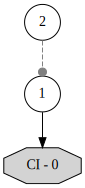

In [12]:
two_levels_continuous_hgf.plot_network()

In [13]:
# add new observations
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(input_data=timeseries)

Add 614 new continuous observations.


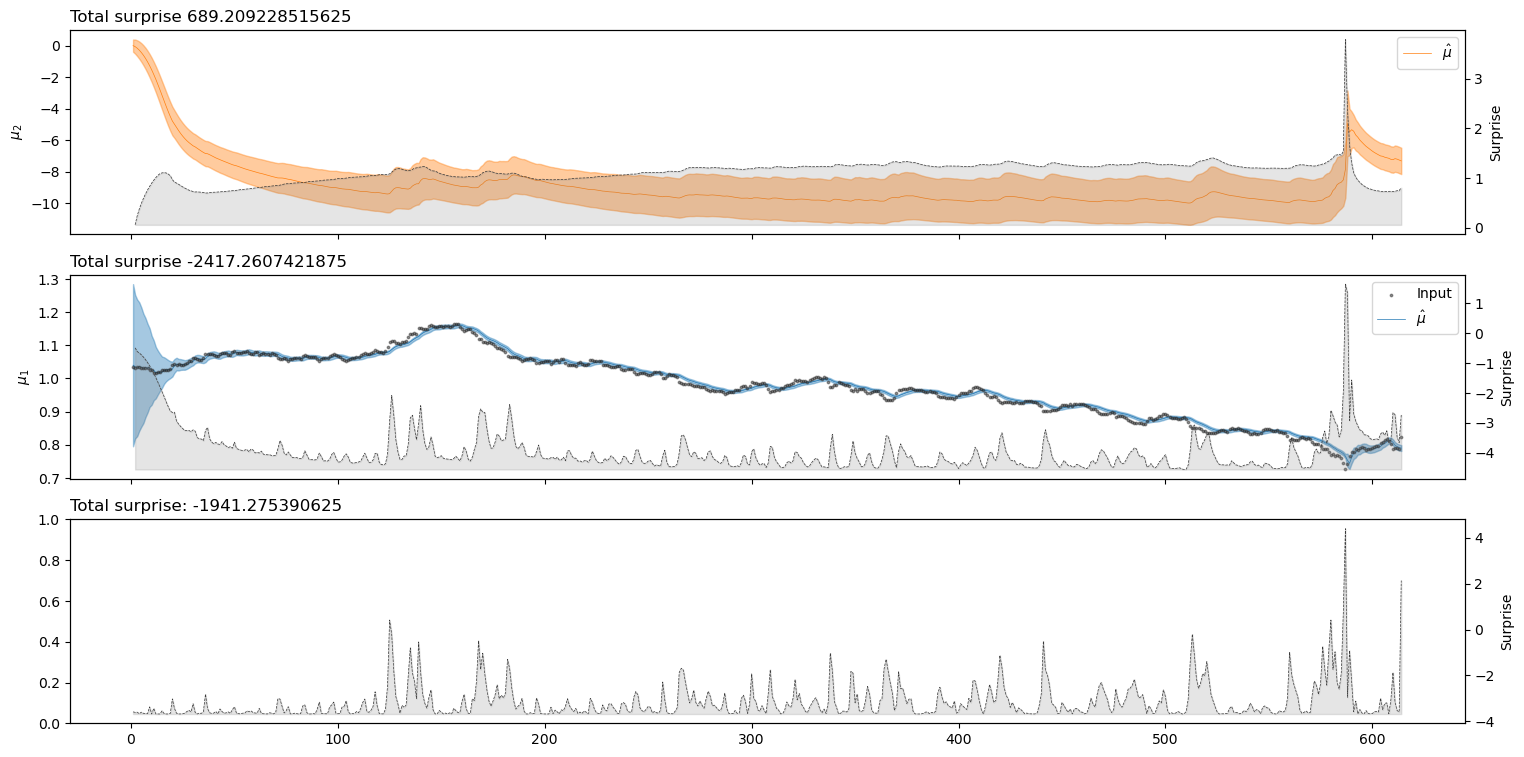

In [14]:
two_levels_continuous_hgf.plot_trajectories();

In [15]:
two_levels_continuous_hgf.surprise()

Array(-1941.2756, dtype=float32)

In [16]:
two_levels_continuous_hgf.node_trajectories

{0: {'kappas': None,
  'omega': Array([-9.2103405, -9.2103405, -9.2103405, -9.2103405, -9.2103405,
         -9.2103405, -9.2103405, -9.2103405, -9.2103405, -9.2103405,
         -9.2103405, -9.2103405, -9.2103405, -9.2103405, -9.2103405,
         -9.2103405, -9.2103405, -9.2103405, -9.2103405, -9.2103405,
         -9.2103405, -9.2103405, -9.2103405, -9.2103405, -9.2103405,
         -9.2103405, -9.2103405, -9.2103405, -9.2103405, -9.2103405,
         -9.2103405, -9.2103405, -9.2103405, -9.2103405, -9.2103405,
         -9.2103405, -9.2103405, -9.2103405, -9.2103405, -9.2103405,
         -9.2103405, -9.2103405, -9.2103405, -9.2103405, -9.2103405,
         -9.2103405, -9.2103405, -9.2103405, -9.2103405, -9.2103405,
         -9.2103405, -9.2103405, -9.2103405, -9.2103405, -9.2103405,
         -9.2103405, -9.2103405, -9.2103405, -9.2103405, -9.2103405,
         -9.2103405, -9.2103405, -9.2103405, -9.2103405, -9.2103405,
         -9.2103405, -9.2103405, -9.2103405, -9.2103405, -9.2103405,
    

```{admonition} Exercise 3
$\omega represents the tonic part of the variance (the part that is not affected by the parent node). Using the code example above, create another model with different values for $\omega$ at the second level. What is the consequence of changing this value on the beliefs trajectories? What is the "best" model in this context?
```

# Parameters optimization

In the final part of the exercise, you will be asked to apply the HGF to real world situation. For example, you can download wheather time series at the following link: https://renewables.ninja/. From there you can try:

* an agent has been living for 20 years in city A and has learn a model of weather that works well in this city, but decide to move and live in city B for one year. He is using the same model to understant weather changes in the new city. 


```{note}
The proposed exercise are more suggestions. You can use any time series that you find interesting, it should just come with a volatility that is interesting to model.
```

In [8]:
import pymc as pm
import numpy as np
from pyhgf.distribution import HGFDistribution
from pyhgf.response import total_gaussian_surprise

hgf_logp_op = HGFDistribution(
    n_levels=2,
    input_data=[timeseries],
    response_function=total_gaussian_surprise
)

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [9]:
with pm.Model() as two_level_hgf:

    # omegas priors
    omega_1 = pm.Uniform("omega_1", -20, -2.0)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=omega_1,
            omega_2=-2.0,
            omega_input=np.log(1e-4),
            rho_1=0.0,
            rho_2=0.0,
            pi_1=1e4,
            pi_2=1e1,
            mu_1=timeseries[0],
            mu_2=0.0,
            kappa_1=1.0,
            omega_3=np.nan,
            rho_3=np.nan,
            pi_3=np.nan,
            mu_3=np.nan,
            kappa_2=np.nan
        ),
    )

NameError: name 'jnp' is not defined

In [ ]:
pm.model_to_graphviz(two_level_hgf)

In [ ]:
with two_level_hgf:
    two_level_hgf_idata = pm.sample(chains=4)